In [568]:
import numpy as np
from matplotlib import pyplot as plt

In [569]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [570]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [571]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


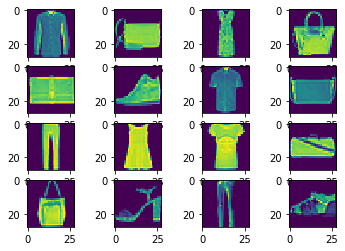

In [572]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

## 3.1 Analytical Gradients

Derived them on ipad, i'd rather confirm the results with someone before typing it all out cause it's painful.

## 3.2 Verifying Gradients Correctness

## 3.3 Implementing the algorithm

In [573]:
# sigmoid for a single sample
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

In [574]:
def sigmoid_d(x):
    return x * (1 - x)

In [575]:
def forward(params, x):
    forward_res = {}
    forward_res["z1"] = np.matmul(params["W1"], x.flatten()) + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = np.matmul(params["W2"], forward_res["a1"]) + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = np.matmul(params["W3"], forward_res["a2"]) + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

In [576]:
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [577]:
def backprop(x, y, params, forward_res):
    grads = {}
    x = x.reshape(28**2,1)
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["W2"].dot(a1) + params["b2"]
    a2 = sigmoid(z2)
    
    z3 = params["W3"].dot(a2) + params["b3"]
    y_pred = a3 = sigmoid(z3)
    
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_d(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(z2) # (20, 1)
    dL_dz1 = np.multiply(dL_dz2.T.dot(params["W2"]).T, sigmoid_d(z1)) # (200, 1)
    
    grads["dW3"] = dL_dz3.dot(a2.T) # (1, 20)
    grads["db3"] = dL_dz3 # (1, 1)
    
    grads["dW2"] = dL_dz2.dot(a1.T) # (20, 200)
    grads["db2"] = dL_dz2 # (20, 1)
    
    grads["dW1"] = dL_dz1.dot(x.T) # (784, 200)
    grads["db1"] = dL_dz1 # (200, 1)

    return grads

In [578]:
def update_params(grads, params, lr, momentum):
#     I DO NOT KNOW WHAT THIS IS
    # with momentum (optional)
    dW1 = momentum * grads["dW1"] + (1 - momentum) * grads["dW1"]
    db1 = momentum * grads["db1"] + (1 - momentum) * grads["db1"]
    dW2 = momentum * grads["dW2"] + (1 - momentum) * grads["dW2"]
    db2 = momentum * grads["db2"] + (1 - momentum) * grads["db2"]
    dW3 = momentum * grads["dW3"] + (1 - momentum) * grads["dW3"]
    db3 = momentum * grads["db3"] + (1 - momentum) * grads["db3"]

#     print('w1', params["W1"])
#     print('dw1', dW1)
#     # gradient descent
    params["W1"] = params["W1"] - (lr * dW1)
    params["b1"] = params["b1"] - lr * db1
    params["W2"] = params["W2"] - (lr * dW2)
    params["b2"] = params["b2"] - lr * db2
    params["W3"] = params["W3"] - (lr * dW3)
    params["b3"] = params["b3"] - lr * db3
    
    return params

In [579]:
def mlp(xs, ys, learning_rate, momentum):
    img_size = 28**2
    h1 = 200
    h2 = 20
    out_size = 1
    
    # initialise parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    
    epoch = 0
    
    while True:
        
        # shuffle training set
        permutation = np.random.permutation(trainxs.shape[0])
        trainxs_shuffled = trainxs[p]
        trainys_shuffled = trainys[p]
        
        print("epoch", epoch)
        for i in range (trainxs.shape[0]):
            forward_res = forward(params, trainxs_shuffled[i])
            grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
            params = update_params(grads, params, learning_rate, momentum)
        accuracy(devxs, devys, params)
        epoch += 1
        

In [580]:
def predict_mlp(x, params, iteration):
    x = x.reshape(28**2,1)
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    z2 = params["W2"].dot(a1) + params["b2"]
    a2 = sigmoid(z2)
    z3 = params["W3"].dot(a2) + params["b3"]
    a3 = sigmoid(z3)
    if a3 >= 0.5:
        return 1
    return 0

In [581]:
# function to calculate accuracy
def accuracy(devxs, devys, params):
    accuracy = 0.0
    for i in range (devxs.shape[0]):
        yp = predict_mlp(devxs[i], params, i)
#         print('yp', yp)
        if (yp == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

## 3.4 Training model to convergence

Convergence is defined as

In [582]:
# define hyperparameters

# full-batch gradient descent, so not using batch_size as a parameter
learning_rate = 0.01
momentum = 0.9

In [ ]:
mlp(trainxs, trainys, learning_rate, momentum)

epoch 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in matmul
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


epoch 1
epoch 2


## 3.5 Loss plot

## 3.6 Accuracy plot

## 3.7 Accuracy for best epoch